This scripts can be used to augment 2D/3D images

In [ ]:
import imageio
import numpy as np
import imgaug as ia
import imgaug.augmenters as iaa
from imgaug.augmentables.segmaps import SegmentationMapsOnImage
import pandas as pd
import cv2
from scipy.ndimage.interpolation import map_coordinates
from scipy.ndimage.filters import gaussian_filter
import matplotlib.pyplot as plt
import skimage.io as io
from medpy.io import load,save
import numpy, imageio, elasticdeform
import glob, os
import shutil
import itertools
import random
import scipy.ndimage as ndimage
from skimage.measure import label,regionprops

path="raw image path"
aug_path="output path"
if not os.path.exists(aug_path):
    os.makedirs(aug_path)
else:
    shutil.rmtree(aug_path)
    os.makedirs(aug_path)

#define the augmentation amtrix and change parameters based on what you want
seq = iaa.Sequential([
    iaa.Multiply((0.9,1.3 ), per_channel=0.2),
    #iaa.AllChannelsCLAHE(),
    iaa.Fliplr(1), # horizontally flip 50% of all images
    iaa.Flipud(1), # vertically flip 20% of all images
    iaa.Dropout([0.01, 0.03]),      # drop 5% or 20% of all pixels
    #iaa.Sharpen(alpha=(0, 1.0), lightness=(0.4, 3.5)),       # sharpen the image
    #affine transformation
    
    #PiecewiseAffine and elastic deformation
    iaa.PiecewiseAffine(scale=(0.01, 0.05)),
    iaa.ElasticTransformation(alpha=50, sigma=9),
    iaa.ElasticTransformation(alpha=50, sigma=10),  # apply water effect (affects segmaps)
    iaa.ElasticTransformation(alpha=50, sigma=11),  # apply water effect (affects segmaps)
    #iaa.LinearContrast((8.0, 10.0), per_channel=0.3)
    iaa.Affine(rotate=(-20, -15),
            translate_percent={"x": (-0.05, 0.05), "y": (-0.05, 0.05),"z": (-0.05, 0.05)},
            scale={"x": (0.8), "y": (0.8),"z":(0.8)}, order=3,
            ),
    
    iaa.Affine(rotate=(-15, -10),
            translate_percent={"x": (-0.05, 0.05), "y": (-0.05, 0.05),"z": (-0.05, 0.05)},
            scale={"x": (0.9), "y": (0.9),"z":(0.9)}, order=3,
            ),
    iaa.Affine(rotate=(-10, -5),
            translate_percent={"x": (-0.05, 0.05), "y": (-0.05, 0.05),"z": (-0.05, 0.05)},
            scale={"x": (1.2), "y": (1.2),"z":(1.2)}, order=3,
            ),
    
    iaa.Affine(rotate=(5, 10),
            translate_percent={"x": (-0.05, 0.05), "y": (-0.05, 0.05),"z": (-0.05, 0.05)},
            scale={"x": (1.3), "y": (1.3),"z":(1.3)}, order=3,
            ),
    iaa.Affine(rotate=(10, 15),
            translate_percent={"x": (-0.05, 0.05), "y": (-0.05, 0.05),"z": (-0.05, 0.05)},
            scale={"x": (0.9), "y": (0.9),"z":(0.9)}, order=3,
            ),
     iaa.Affine(rotate=(15, 20),
            translate_percent={"x": (-0.05, 0.05), "y": (-0.05, 0.05),"z": (-0.05, 0.05)},
            scale={"x": (0.8), "y": (0.8),"z":(0.8)}, order=3,
            ),
    
              
], random_order=False)

#change data orientations
def permute_data(data, key):
    """
    Permutes the given data according to the specification of the given key. Input data
    must be of shape (n_modalities, x, y, z).

    Input key is a tuple: (rotate_y, rotate_z), flip_x, flip_y, flip_z, transpose)

    As an example, ((0, 1), 0, 1, 0, 1) represents a permutation in which the data is
    rotated 90 degrees around the z-axis, then reversed on the y-axis, and then
    transposed.
    """
    data = np.copy(data)
    (rotate_y, rotate_z), flip_x, flip_y, flip_z, transpose = key

    if rotate_y != 0:
        data = np.rot90(data, rotate_y, axes=(0, 2))
    if rotate_z != 0:
        data = np.rot90(data, rotate_z, axes=(1, 2))
    if flip_x:
        data = data[:, ::-1]
    if flip_y:
        data = data[:, :, ::-1]
    if flip_z:
        data = data[:, :, ::-1]
    return data
#crop volume based on center of mass
def crop_volume(img,mask,thresholds):
    tmp_mask=np.zeros_like(mask)
    tmp_mask[mask==1.0]=1
    center_mass=ndimage.measurements.center_of_mass(mask)   
    x=int(center_mass[0]-thresholds[0])
    y=int(center_mass[1]-thresholds[1])+thresholds[3]
    z=int(center_mass[2]-thresholds[2])
    if x<0:
        x=0
    if y<0:
        y=0
    if z<0:
        z=0
    
    mask=mask[x:x+2*thresholds[0],y:y+2*thresholds[1],z:z+2*thresholds[2]]
    img=img[x:x+2*thresholds[0],y:y+2*thresholds[1],z:z+2*thresholds[2]]
    return img,mask
def rotate_volume(img,seg_img, axes,prefix,img_header,seg_header,thresholds): 
        deg=[-20,-15,-10,-5,5,10,15,20]
        i=0
        for angl in deg:

            rotated_img=ndimage.interpolation.rotate(img,angle=angl,axes=axes,order=5, reshape=False, mode="constant");
            rotated_seg=ndimage.filters.median_filter(seg_img, mode="constant", size=(5,5,3))
            rotated_seg[rotated_seg>0]=2**15
            rotated_seg=ndimage.interpolation.rotate(rotated_seg,angle=angl,axes=axes,reshape=False,order=1,mode="constant");
            rotated_seg[rotated_seg>0.00]=1.0
            rotated_seg[rotated_seg<=0.00]=0.0
            rotated_seg=ndimage.filters.median_filter(rotated_seg, mode="constant", size=(5,5,3))
            os.makedirs(aug_path+dirname+prefix+"_"+str(i))
            rotated_img,rotated_seg=crop_volume(rotated_img,rotated_seg,thresholds)
            save(rotated_img,aug_path+dirname+prefix+"_"+str(i)+"/"+dirname+prefix+"_"+str(i)+"_brain.nii.gz",hdr=img_header,use_compression=False)
            save(rotated_seg,aug_path+dirname+prefix+"_"+str(i)+"/"+dirname+prefix+"_"+str(i)+"_seg.nii.gz",hdr=seg_header,use_compression=False)
            i=i+1

def zoom_image(img,seg_img,prefix,img_header,seg_header):
    factors=[0.8,0.9,1.1,1.2]
    i=0
    for factor in factors:
        rotated_img=ndimage.zoom(img,zoom=factor,mode='nearest', order=5);
        rotated_seg=ndimage.zoom(seg_img,zoom=factor,mode='nearest', order=0);
        os.makedirs(aug_path+dirname+prefix+"_"+str(i))
        save(rotated_img,aug_path+dirname+prefix+"_"+str(i)+"/"+dirname+prefix+"_"+str(i)+"_brain.nii.gz",hdr=img_header,use_compression=False)
        save(rotated_seg,aug_path+dirname+prefix+"_"+str(i)+"/"+dirname+prefix+"_"+str(i)+"_seg.nii.gz",hdr=seg_header,use_compression=False)
        i=i+1
    

      
def apply_augmentation(seq_picked,image,segmap,dirname,i,img_header,seg_header, thresholds):
    """ apply augmentation on each image and mask
    """
    dist_image, dist_mask= seq_picked(image=image, segmentation_maps=segmap)
    os.makedirs(aug_path+dirname+"_"+str(i))
    #print(dist_mask.shape)
    dist_image,dist_mask=crop_volume(dist_image,dist_mask.get_arr(), thresholds)
    dist_mask=ndimage.filters.median_filter(dist_mask, mode="constant", size=(3,3,3))
    save(dist_mask,aug_path+dirname+"_"+str(i)+"/"+dirname+"_"+str(i)+"_seg.nii.gz",hdr=seg_header,use_compression=False)
    save(dist_image,aug_path+dirname+"_"+str(i)+"/"+dirname+"_"+str(i)+"_brain.nii.gz",hdr=img_header,use_compression=False)
    
    return dist_image


thresholds=(224,224,24,0)
#thresholds=(128,112,144,0)

#read all files and apply augmentation
for file in glob.glob(path+"*"):
    """ apply augmentation on each image and mask"""
    dirname=os.path.basename(file)
    print(dirname)
    image_path=file+"/"+dirname+"_brain.nii.gz"
    mask_path=file+"/"+dirname+"_seg.nii.gz"
    image,img_header=load(image_path)
    mask,seg_header=load(mask_path)
    #mask=ndimage.filters.median_filter(mask, mode="constant", size=(3,3,3))
    
    segmap = SegmentationMapsOnImage(mask, shape=image.shape)
    seq_all=[]
    
    for i in range(len(seq)):
        
        seq_picked=iaa.Sequential([seq[i]])
        apply_augmentation(seq_picked,image,segmap,dirname,i,img_header,seg_header,thresholds)
        seq_all.append(seq[i])


    
    #zoom_image(image,mask,"zoom",img_header,seg_header)
    #rotate_volume(image,mask, (0,2),"roty",img_header,seg_header,thresholds)
    #rotate_volume(image,mask, (1,2),"rotx",img_header,seg_header)
    
    os.makedirs(aug_path+dirname)
    image,mask=crop_volume(image,mask,thresholds)
    save(image,aug_path+dirname+"/"+dirname+"_brain.nii.gz",hdr=img_header, use_compression=False)
    save(mask,aug_path+dirname+"/"+dirname+"_seg.nii.gz",hdr=seg_header, use_compression=False)
    
    '''
    keys=set(itertools.product(itertools.combinations_with_replacement(range(2), 2), range(2), range(2), range(2), range(2)))
    key=random.choice(list(keys))
    dist_image = permute_data(image,key)
    dist_mask = permute_data(mask,key)
    
    os.makedirs(aug_path+dirname+"rotx")
    save(dist_image,aug_path+dirname+"rotx/"+dirname+"rotx_brain.nii.gz")
    save(dist_mask,aug_path+dirname+"rotx/"+dirname+"rotx_seg.nii.gz")
    '''   



Visualize Augmented image

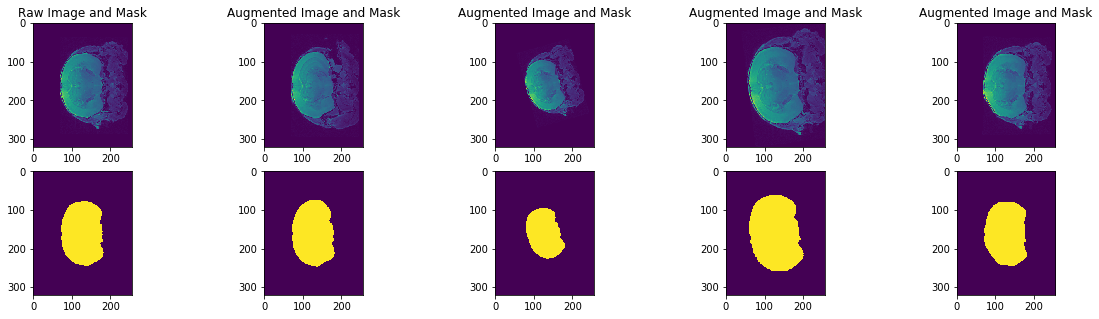

In [8]:
from medpy.io import load, save
import glob,os
import matplotlib.pyplot as plt
path="output path"
fig,ax=plt.subplots(ncols=5,nrows=2,figsize=(20,5))
j=0

for files in glob.glob(path+"BDH6240*"):
    filename=os.path.basename(files)
    img,h=load(files+"/"+filename+"_brain.nii.gz")
    seg,h=load(files+"/"+filename+"_seg.nii.gz")
    ax[0,j].imshow(img[:,:,150])
    ax[0,j].set_title("Augmented Image and Mask")
    ax[1,j].imshow(seg[:,:,150])
    j=j+1
ax[0,0].set_title("Raw Image and Mask")
plt.show()

